# Machine Learning Models and Ensemble Method
---


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

SEED = 111 # constant seed for reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## Train/Test Split:

In [132]:
df = pd.read_csv("UFC_TRAIN.csv")

# tackling imbalance issue
theMin = df["Winner"].value_counts().min()
minority = df[df["Winner"]==1].iloc[0:theMin]
undersampleMaj = df[df["Winner"]==0].iloc[0:theMin]
df = pd.concat([minority, undersampleMaj], axis=0)
df["Winner"].value_counts()

# train/test split
X = df.drop(["Winner","B_fighter","R_fighter"], axis=1).values
y = df["Winner"].values
X_TRAIN, X_TEST, y_TRAIN, y_TEST = train_test_split(X,y, test_size=0.1, random_state=SEED)



## ML Models
### 1- DNN:

In [133]:
# scaling
scaler = MinMaxScaler()
scaler.fit(X_TRAIN)
X_train = scaler.transform(X_TRAIN)
X_test = scaler.transform(X_TEST)
y_train = y_TRAIN
y_test = y_TEST
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape} | y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")

# model
dnnClf = Sequential()

# input layer
dnnClf.add(Dense(units=42, activation='relu'))
dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

# h1
dnnClf.add(Dense(units=42, activation='relu'))
dnnClf.add(Dropout(0.5))

# h2
dnnClf.add(Dense(units=42, activation='relu'))
dnnClf.add(Dropout(0.5))

# output layer
dnnClf.add(Dense(units=1, activation='sigmoid'))

dnnClf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping # prevent diverge of loss & val_loss
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=16)

X_train shape: (2404, 42) | X_test shape: (268, 42) | y_train shape: (2404,) | y_test shape: (268,)


Train on 2404 samples, validate on 268 samples
Epoch 1/500
2404/2404 [==============================] - 3s 1ms/sample - loss: 0.6998 - accuracy: 0.5012 - val_loss: 0.6962 - val_accuracy: 0.4739
Epoch 2/500
2404/2404 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.50 - 0s 173us/sample - loss: 0.6986 - accuracy: 0.4979 - val_loss: 0.6942 - val_accuracy: 0.4590
Epoch 3/500
2404/2404 [==============================] - 1s 306us/sample - loss: 0.6908 - accuracy: 0.5266 - val_loss: 0.6934 - val_accuracy: 0.4701
Epoch 4/500
2404/2404 [==============================] - 1s 271us/sample - loss: 0.6942 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy: 0.4888
Epoch 5/500
2404/2404 [==============================] - 1s 222us/sample - loss: 0.6922 - accuracy: 0.5108 - val_loss: 0.6936 - val_accuracy: 0.4627
Epoch 6/500
2404/2404 [==============================] - 1s 275us/sample - loss: 0.6890 - accuracy: 0.5395 - val_loss: 0.6940 - val_accuracy: 0.4813
Epoch 7/500
2404/24

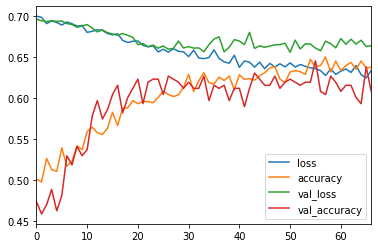

In [134]:
dnnClf.fit(x=X_train, 
          y=y_train, 
          epochs=500,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )
model_loss = pd.DataFrame(dnnClf.history.history)
model_loss.plot()

In [21]:
dnnPreds = dnnClf.predict(scaler.transform(X_TEST))
dnnPreds = [round(i[0]) for i in dnnPreds]
dnnAcc = metrics.accuracy_score(dnnPreds, y_TEST)
print(dnnAcc)

0.6380597014925373


### 2- SVM:

In [22]:
svmClf = SVC(gamma='auto',verbose=1)
svmClf.fit(X_TRAIN, y_TRAIN)
svmPreds = svmClf.predict(X_TEST)
svmAcc = metrics.accuracy_score(svmPreds, y_TEST)
print(svmAcc)

[LibSVM]0.5522388059701493


### 3- RF:

In [24]:
rfClf = RandomForestRegressor(n_estimators = 100, random_state = SEED)
rfClf.fit(X_TRAIN, y_TRAIN)
rfPreds = rfClf.predict(X_TEST)
rfPreds = [round(i) for i in rfPreds]
rfAcc = metrics.accuracy_score(rfPreds,y_TEST)
print(rfAcc)


0.6567164179104478


### 4- Ensemble Method:

In [125]:
def ensemble(sample):
    ensPred = []
    dnnPred = dnnClf.predict(scaler.transform(sample.reshape(1,-1))).tolist()[0][0]
    svmPred = svmClf.predict(sample.reshape(1,-1)).tolist()[0]
    rfPred = rfClf.predict(sample.reshape(1,-1)).tolist()[0]
    
    ensPred.append([dnnPred,svmPred,rfPred])
    ensPred = [round(i) for i in ensPred[0]]
    return(max(set(ensPred), key=ensPred.count))

final_preds = []
for i,e in enumerate(X_TEST):
    final_preds.append(ensemble(e))
    
metrics.accuracy_score(final_preds,y_TEST)

0.6492537313432836